In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import legendre

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set matplotlib style (gracefully handle if style doesn't exist)
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        pass  # Use default style

%matplotlib inline


## Polynomial Regression as a Linear Combination of Basis Functions

In the previous notebook, we explored polynomial regression by creating polynomial features and fitting models of varying degrees. Now, we'll examine the **mathematical foundations** of this approach from a linear algebra perspective.

### The Linear Combination View

Polynomial regression can be understood as finding a **linear combination of basis functions**. For a polynomial of degree $d$, we express the prediction as:

$$y = \sum_{j=0}^{d} \beta_j \phi_j(x)$$

where:
- $\beta_j$ are the **coefficients** (parameters to be learned)
- $\phi_j(x)$ are **basis functions** that transform the input $x$

### Power Basis Functions

In the standard polynomial regression we've been using, the basis functions are the **power basis**:

$$\phi_0(x) = 1, \quad \phi_1(x) = x, \quad \phi_2(x) = x^2, \quad \ldots, \quad \phi_d(x) = x^d$$

This gives us the familiar polynomial form:

$$y = \beta_0 + \beta_1 x + \beta_2 x^2 + \ldots + \beta_d x^d$$

### Matrix Formulation

When we have $n$ data points, we can write this in matrix form:

$$\mathbf{y} = \mathbf{X}\boldsymbol{\beta}$$

where:
- $\mathbf{y} \in \mathbb{R}^{n \times 1}$ is the vector of target values
- $\mathbf{X} \in \mathbb{R}^{n \times (d+1)}$ is the **design matrix** (also called the **Vandermonde matrix** for the power basis)
- $\boldsymbol{\beta} \in \mathbb{R}^{(d+1) \times 1}$ is the vector of coefficients

Each row of $\mathbf{X}$ contains the basis function evaluations for one data point: $[1, x_i, x_i^2, \ldots, x_i^d]$.

This linear algebra perspective reveals that polynomial regression is fundamentally about finding the best linear combination of basis functions to approximate our data.


Vandermonde Matrix Structure
Input x shape: torch.Size([50, 1])
Vandermonde matrix V shape: torch.Size([50, 6])
Polynomial degree: 5

First few rows of Vandermonde matrix (showing structure):
----------------------------------------------------------------------
x values: [-2.        -1.9183674 -1.8367347 -1.755102  -1.6734694]

Vandermonde matrix (first 5 rows, all 6 columns):
[[  1.         -2.          4.         -8.         16.        -32.       ]
 [  1.         -1.9183674   3.6801333  -7.059848   13.543382  -25.981182 ]
 [  1.         -1.8367347   3.3735943  -6.1963973  11.381138  -20.90413  ]
 [  1.         -1.755102    3.080383   -5.406387    9.48876   -16.653744 ]
 [  1.         -1.6734694   2.8005     -4.686551    7.8427997 -13.124685 ]]


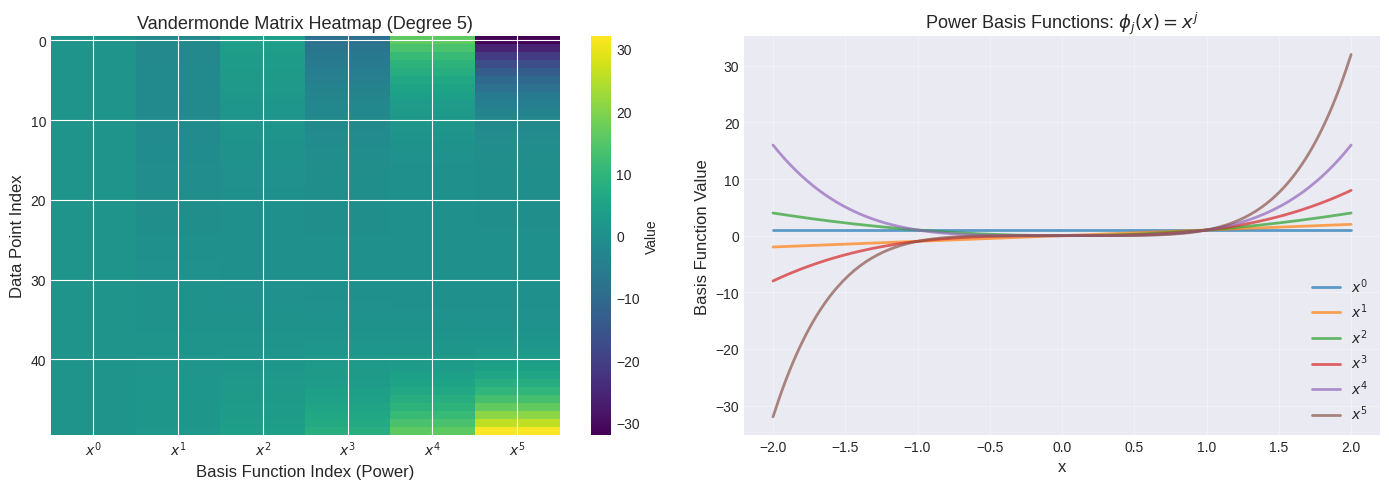


Note: The Vandermonde matrix is the design matrix X in the linear system y = Xβ
Each column represents one basis function evaluated at all data points.


In [2]:
# Generate synthetic data for demonstration
# We'll use a similar setup to the previous notebook but focus on higher degrees
n_samples = 50
x_min, x_max = -2.0, 2.0
sigma = 0.3

# Generate x values uniformly
x = torch.linspace(x_min, x_max, n_samples).unsqueeze(1)

# Generate true function values (quadratic with some higher-order terms)
y_true = 0.5 * x ** 2 + 0.1 * x ** 3

# Generate noise
epsilon = torch.normal(mean=0.0, std=sigma, size=(n_samples, 1))
y = y_true + epsilon

# Function to construct Vandermonde matrix for power basis
def construct_vandermonde_matrix(x, degree):
    """
    Construct Vandermonde matrix for power basis.
    
    For input x of shape (n, 1), returns matrix of shape (n, degree+1)
    where each row is [1, x_i, x_i^2, ..., x_i^degree]
    
    This is equivalent to create_polynomial_features from the previous notebook.
    """
    n = x.shape[0]
    x_flat = x.squeeze()
    
    # Create matrix using einsum and broadcasting
    # We'll stack powers: for each power j, compute x^j
    powers = torch.arange(degree + 1, dtype=x.dtype, device=x.device)
    # Use broadcasting: (n, 1) ** (1, degree+1) -> (n, degree+1)
    vandermonde = x_flat.unsqueeze(1) ** powers.unsqueeze(0)
    
    return vandermonde

# Construct Vandermonde matrix for degree 5
degree = 5
V = construct_vandermonde_matrix(x, degree)

print("=" * 70)
print("Vandermonde Matrix Structure")
print("=" * 70)
print(f"Input x shape: {x.shape}")
print(f"Vandermonde matrix V shape: {V.shape}")
print(f"Polynomial degree: {degree}")
print(f"\nFirst few rows of Vandermonde matrix (showing structure):")
print("-" * 70)
print(f"x values: {x[:5].squeeze().numpy()}")
print(f"\nVandermonde matrix (first 5 rows, all {degree+1} columns):")
print(V[:5, :].numpy())
print("=" * 70)

# Visualize the Vandermonde matrix structure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap of the Vandermonde matrix
im1 = axes[0].imshow(V.numpy(), aspect='auto', cmap='viridis', interpolation='nearest')
axes[0].set_xlabel('Basis Function Index (Power)', fontsize=12)
axes[0].set_ylabel('Data Point Index', fontsize=12)
axes[0].set_title(f'Vandermonde Matrix Heatmap (Degree {degree})', fontsize=13)
axes[0].set_xticks(range(degree + 1))
axes[0].set_xticklabels([f'$x^{i}$' for i in range(degree + 1)])
plt.colorbar(im1, ax=axes[0], label='Value')

# Plot individual basis functions
x_plot = torch.linspace(x_min, x_max, 200).unsqueeze(1)
V_plot = construct_vandermonde_matrix(x_plot, degree)

axes[1].plot(x_plot.numpy(), V_plot.numpy(), linewidth=2, alpha=0.7)
axes[1].set_xlabel('x', fontsize=12)
axes[1].set_ylabel('Basis Function Value', fontsize=12)
axes[1].set_title(f'Power Basis Functions: $\\phi_j(x) = x^j$', fontsize=13)
axes[1].legend([f'$x^{j}$' for j in range(degree + 1)], fontsize=10, loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nNote: The Vandermonde matrix is the design matrix X in the linear system y = Xβ")
print("Each column represents one basis function evaluated at all data points.")


## Basis Functions: Generalizing Polynomial Regression

### What Are Basis Functions?

**Basis functions** are a set of functions that span a function space. In polynomial regression, we're approximating an unknown function $f(x)$ as a linear combination of basis functions:

$$f(x) \approx \sum_{j=0}^{d} \beta_j \phi_j(x)$$

The choice of basis functions $\{\phi_j(x)\}$ determines:
- The **expressive power** of our model (what functions we can represent)
- The **numerical properties** of the design matrix (conditioning, stability)
- The **interpretability** of the coefficients

### Power Basis: The Standard Choice

The **power basis** $\{1, x, x^2, \ldots, x^d\}$ is the most intuitive choice:
- Simple to understand and implement
- Can represent any polynomial of degree $d$
- However, it has **poor numerical properties** for high degrees:
  - Columns become nearly linearly dependent (ill-conditioned)
  - Large values for high powers when $|x| > 1$
  - Numerical instability in coefficient estimation

### Alternative Basis Functions

Different basis functions offer better numerical properties:

1. **Legendre Polynomials**: Orthogonal on $[-1, 1]$, better conditioning
2. **Chebyshev Polynomials**: Minimize maximum error, excellent for approximation
3. **Hermite Polynomials**: Orthogonal with respect to Gaussian weight
4. **Fourier Basis**: $\{1, \sin(x), \cos(x), \sin(2x), \cos(2x), \ldots\}$ for periodic functions
5. **Radial Basis Functions**: For non-polynomial approximations

### Why This Matters

The **design matrix** $\mathbf{X}$ (where $X_{ij} = \phi_j(x_i)$) determines the numerical stability of solving the least squares problem. A well-conditioned design matrix leads to:
- More stable coefficient estimates
- Better generalization
- Reduced sensitivity to noise

By choosing appropriate basis functions, we can improve the numerical properties of polynomial regression without changing the fundamental approach.


Numerical Properties Comparison: Power Basis vs Legendre Polynomials
Polynomial degree: 10
Number of samples: 50

Condition Numbers:
  Power basis (Vandermonde):     1.31e+04
  Legendre polynomials:          8.59e+04
  Improvement factor:             0.15x


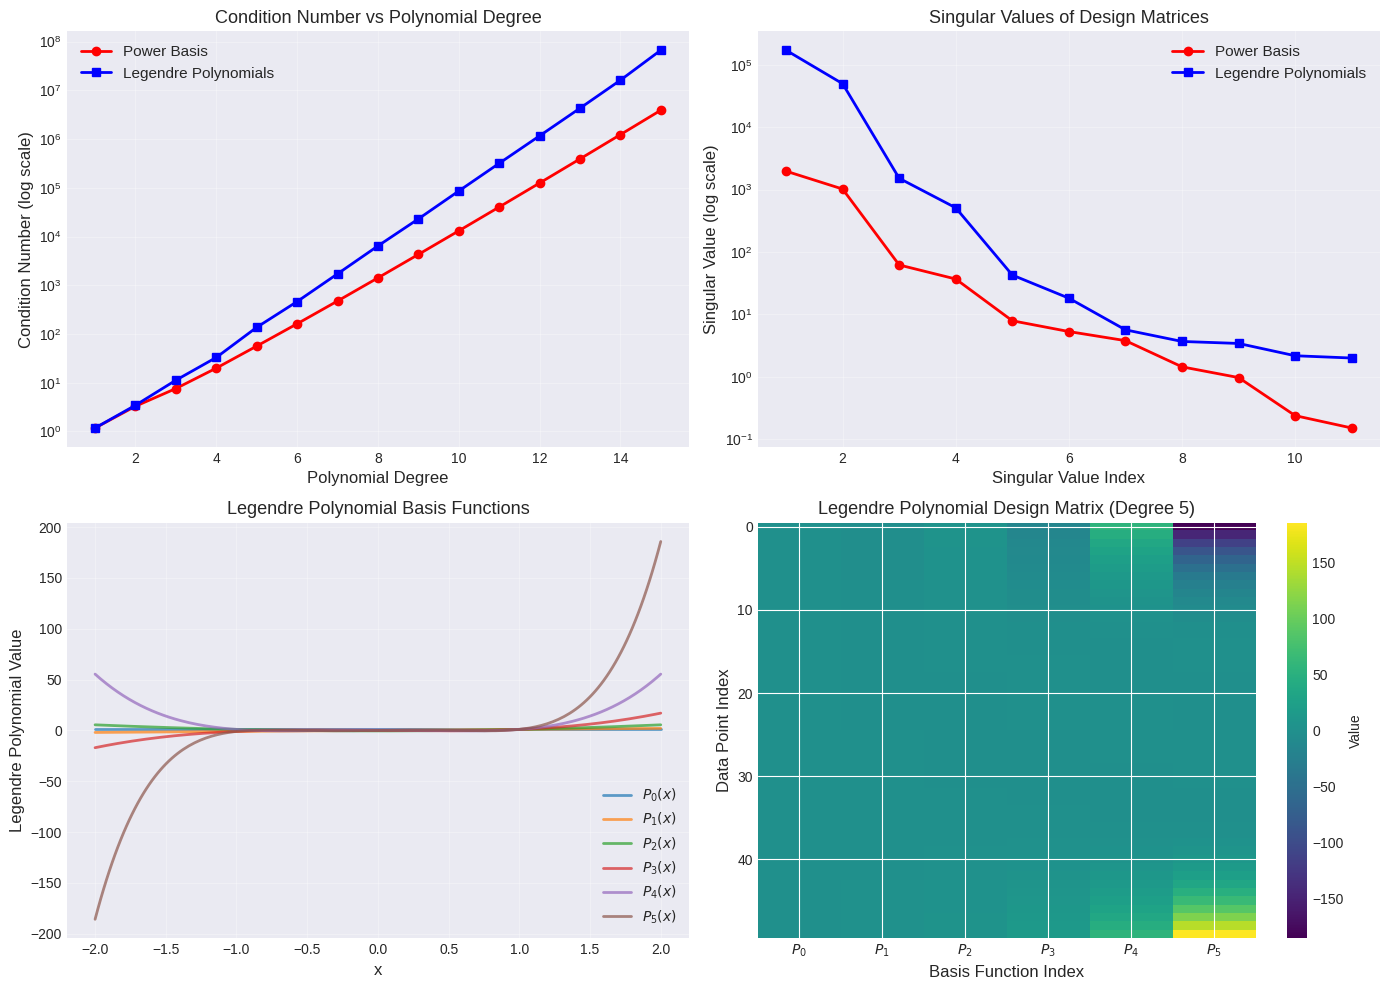


Key Insight: Legendre polynomials provide much better numerical conditioning,
especially for higher degrees, making them more suitable for numerical stability.


In [3]:
# Function to evaluate Legendre polynomials
def evaluate_legendre_polynomials(x, degree):
    """
    Evaluate Legendre polynomials up to specified degree.
    
    Legendre polynomials are orthogonal on [-1, 1] and have better
    numerical properties than the power basis.
    
    Returns matrix of shape (n, degree+1) where each column is a Legendre polynomial.
    """
    n = x.shape[0]
    x_flat = x.squeeze()
    
    # Normalize x to [-1, 1] if needed (Legendre polynomials are defined on [-1, 1])
    # For our data range, we'll assume x is already in a reasonable range
    # or normalize it
    x_normalized = x_flat
    
    # Initialize matrix to store Legendre polynomial values
    legendre_matrix = torch.zeros(n, degree + 1, dtype=x.dtype, device=x.device)
    
    # Legendre polynomials can be computed using recurrence relation:
    # P_0(x) = 1
    # P_1(x) = x
    # P_n(x) = ((2n-1)x*P_{n-1}(x) - (n-1)*P_{n-2}(x)) / n
    
    if degree >= 0:
        legendre_matrix[:, 0] = 1.0  # P_0(x) = 1
    
    if degree >= 1:
        legendre_matrix[:, 1] = x_normalized  # P_1(x) = x
    
    # Compute higher-order Legendre polynomials using recurrence
    for j in range(2, degree + 1):
        legendre_matrix[:, j] = ((2*j - 1) * x_normalized * legendre_matrix[:, j-1] - 
                                 (j - 1) * legendre_matrix[:, j-2]) / j
    
    return legendre_matrix

# Alternative: Use scipy's legendre and convert to torch (for verification)
def evaluate_legendre_scipy(x, degree):
    """Evaluate Legendre polynomials using scipy and convert to torch."""
    x_np = x.squeeze().numpy()
    n = len(x_np)
    legendre_matrix = torch.zeros(n, degree + 1, dtype=x.dtype)
    
    for j in range(degree + 1):
        P_j = legendre(j)
        legendre_matrix[:, j] = torch.from_numpy(P_j(x_np))
    
    return legendre_matrix

# Construct design matrices for both bases
degree = 10
V_power = construct_vandermonde_matrix(x, degree)
V_legendre = evaluate_legendre_polynomials(x, degree)

# Compute condition numbers
cond_power = torch.linalg.cond(V_power)
cond_legendre = torch.linalg.cond(V_legendre)

print("=" * 70)
print("Numerical Properties Comparison: Power Basis vs Legendre Polynomials")
print("=" * 70)
print(f"Polynomial degree: {degree}")
print(f"Number of samples: {n_samples}")
print(f"\nCondition Numbers:")
print(f"  Power basis (Vandermonde):     {cond_power.item():.2e}")
print(f"  Legendre polynomials:          {cond_legendre.item():.2e}")
print(f"  Improvement factor:             {cond_power.item() / cond_legendre.item():.2f}x")
print("=" * 70)

# Compute singular values for both matrices
U_power, S_power, Vt_power = torch.linalg.svd(V_power, full_matrices=False)
U_legendre, S_legendre, Vt_legendre = torch.linalg.svd(V_legendre, full_matrices=False)

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Condition numbers vs degree
degrees_range = range(1, 16)
cond_power_list = []
cond_legendre_list = []

for d in degrees_range:
    V_p = construct_vandermonde_matrix(x, d)
    V_l = evaluate_legendre_polynomials(x, d)
    cond_power_list.append(torch.linalg.cond(V_p).item())
    cond_legendre_list.append(torch.linalg.cond(V_l).item())

axes[0, 0].semilogy(degrees_range, cond_power_list, 'o-', linewidth=2, markersize=6, 
                    label='Power Basis', color='red')
axes[0, 0].semilogy(degrees_range, cond_legendre_list, 's-', linewidth=2, markersize=6, 
                    label='Legendre Polynomials', color='blue')
axes[0, 0].set_xlabel('Polynomial Degree', fontsize=12)
axes[0, 0].set_ylabel('Condition Number (log scale)', fontsize=12)
axes[0, 0].set_title('Condition Number vs Polynomial Degree', fontsize=13)
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Singular values
axes[0, 1].semilogy(range(1, len(S_power) + 1), S_power.numpy(), 'o-', 
                    linewidth=2, markersize=6, label='Power Basis', color='red')
axes[0, 1].semilogy(range(1, len(S_legendre) + 1), S_legendre.numpy(), 's-', 
                    linewidth=2, markersize=6, label='Legendre Polynomials', color='blue')
axes[0, 1].set_xlabel('Singular Value Index', fontsize=12)
axes[0, 1].set_ylabel('Singular Value (log scale)', fontsize=12)
axes[0, 1].set_title('Singular Values of Design Matrices', fontsize=13)
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Legendre basis functions
x_plot = torch.linspace(x_min, x_max, 200).unsqueeze(1)
V_legendre_plot = evaluate_legendre_polynomials(x_plot, min(degree, 5))

axes[1, 0].plot(x_plot.numpy(), V_legendre_plot.numpy(), linewidth=2, alpha=0.7)
axes[1, 0].set_xlabel('x', fontsize=12)
axes[1, 0].set_ylabel('Legendre Polynomial Value', fontsize=12)
axes[1, 0].set_title('Legendre Polynomial Basis Functions', fontsize=13)
axes[1, 0].legend([f'$P_{j}(x)$' for j in range(min(degree + 1, 6))], fontsize=10, loc='best')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Matrix structure comparison (heatmaps for degree 5)
V_power_small = construct_vandermonde_matrix(x, 5)
V_legendre_small = evaluate_legendre_polynomials(x, 5)

im1 = axes[1, 1].imshow(V_legendre_small.numpy(), aspect='auto', cmap='viridis', 
                        interpolation='nearest')
axes[1, 1].set_xlabel('Basis Function Index', fontsize=12)
axes[1, 1].set_ylabel('Data Point Index', fontsize=12)
axes[1, 1].set_title('Legendre Polynomial Design Matrix (Degree 5)', fontsize=13)
axes[1, 1].set_xticks(range(6))
axes[1, 1].set_xticklabels([f'$P_{i}$' for i in range(6)])
plt.colorbar(im1, ax=axes[1, 1], label='Value')

plt.tight_layout()
plt.show()

print("\nKey Insight: Legendre polynomials provide much better numerical conditioning,")
print("especially for higher degrees, making them more suitable for numerical stability.")


## Linear Least Squares and the Normal Equation

### The Least Squares Problem

Given a design matrix $\mathbf{X} \in \mathbb{R}^{n \times p}$ and target vector $\mathbf{y} \in \mathbb{R}^{n}$, we want to find coefficients $\boldsymbol{\beta} \in \mathbb{R}^{p}$ that minimize the **residual sum of squares**:

$$\min_{\boldsymbol{\beta}} \|\mathbf{X}\boldsymbol{\beta} - \mathbf{y}\|^2$$

This is the **Linear Least Squares** problem. The squared norm $\|\mathbf{X}\boldsymbol{\beta} - \mathbf{y}\|^2$ measures how well our linear combination of basis functions fits the data.

### The Normal Equation

When $\mathbf{X}$ has full column rank (i.e., the columns are linearly independent), the solution is given by the **Normal Equation**:

$$\boldsymbol{\beta} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}$$

**Derivation**: 
- Set the gradient of the objective function to zero: $\nabla_{\boldsymbol{\beta}} \|\mathbf{X}\boldsymbol{\beta} - \mathbf{y}\|^2 = 0$
- This gives: $\mathbf{X}^T (\mathbf{X}\boldsymbol{\beta} - \mathbf{y}) = 0$
- Rearranging: $\mathbf{X}^T \mathbf{X} \boldsymbol{\beta} = \mathbf{X}^T \mathbf{y}$
- Solving: $\boldsymbol{\beta} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}$

### When the Normal Equation Works

The Normal Equation is applicable when:
- $\mathbf{X}$ has **full column rank** (linearly independent columns)
- $\mathbf{X}^T \mathbf{X}$ is **invertible** (positive definite)
- The system is **well-conditioned** (condition number is not too large)

### Limitations

The Normal Equation can fail when:
- **Ill-conditioned systems**: If $\mathbf{X}^T \mathbf{X}$ is nearly singular, computing its inverse is numerically unstable
- **Overparameterized systems**: When $p > n$ (more parameters than data points), $\mathbf{X}^T \mathbf{X}$ is singular
- **Rank-deficient systems**: When columns of $\mathbf{X}$ are linearly dependent

In these cases, we need alternative methods like the **Moore-Penrose pseudoinverse** or **regularization**.


Coefficient Computation Comparison: Normal Equation vs Pseudoinverse

Well-conditioned case (degree 3):
  Condition number: 7.61e+00

  Normal Equation coefficients:
    [0.0386839  0.04653387 0.4928048  0.08004531]
  Pseudoinverse coefficients:
    [0.0386838  0.04653427 0.4928047  0.08004519]

  Coefficient difference (L2 norm):
    4.35e-07

  Residual norms:
    Normal Equation: 4.813692
    Pseudoinverse:   4.813692

----------------------------------------------------------------------
Ill-conditioned case (degree 12):
  Condition number: 1.25e+05

  Normal Equation coefficients (first 5):
    [ 0.2853935  -0.40773198 -0.872264    1.8512485   2.097592  ]
  Pseudoinverse coefficients (first 5):
    [ 0.3215932  -0.48287463 -1.5037472   2.2056527   3.959299  ]

  Coefficient difference (L2 norm):
    3.057023

  Residual norms:
    Normal Equation: 4.319144
    Pseudoinverse:   3.194058



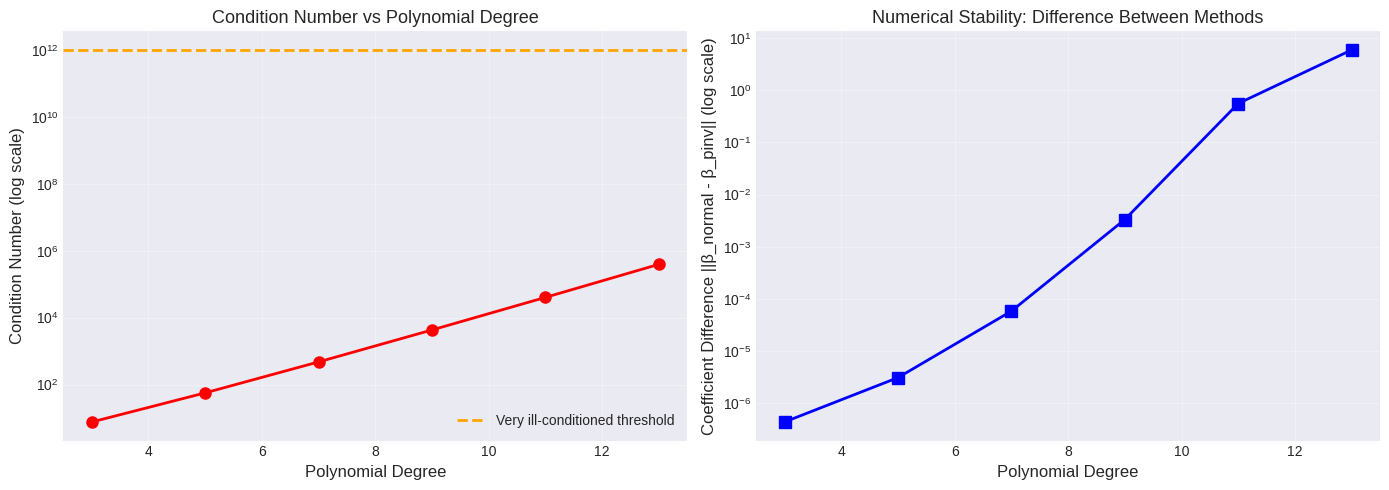


Observation: As condition number increases, the difference between
Normal Equation and pseudoinverse solutions grows, indicating numerical instability.


In [4]:
# Function to compute coefficients using Normal Equation
def solve_normal_equation(X, y):
    """
    Solve least squares using Normal Equation: β = (X^T X)^(-1) X^T y
    
    Uses einsum for matrix operations.
    """
    # Compute X^T X using einsum: (n, p) -> (p, n) @ (n, p) -> (p, p)
    XTX = torch.einsum('ij,ik->jk', X, X)
    
    # Compute X^T y using einsum: (p, n) @ (n, 1) -> (p, 1)
    y_flat = y.squeeze()
    XTy = torch.einsum('ij,i->j', X, y_flat).unsqueeze(1)
    
    # Solve: β = (X^T X)^(-1) X^T y
    try:
        beta = torch.linalg.inv(XTX) @ XTy
    except:
        # If inversion fails, use solve
        beta = torch.linalg.solve(XTX, XTy)
    
    return beta

# Function to compute coefficients using pseudoinverse
def solve_pseudoinverse(X, y):
    """
    Solve least squares using Moore-Penrose pseudoinverse: β = X^+ y
    
    Uses einsum for matrix-vector multiplication.
    """
    # Compute pseudoinverse
    X_pinv = torch.linalg.pinv(X)
    
    # Multiply: β = X^+ y using einsum
    # X_pinv has shape (p, n), y_flat has shape (n,), result has shape (p,)
    y_flat = y.squeeze()
    beta = torch.einsum('ij,j->i', X_pinv, y_flat).unsqueeze(1)
    
    return beta

# Function to compute residuals using einsum
def compute_residuals(X, y, beta):
    """Compute residuals: r = y - Xβ using einsum."""
    y_pred = torch.einsum('ij,jk->ik', X, beta)
    residuals = y - y_pred
    return residuals

# Function to compute residual norm using einsum
def compute_residual_norm(X, y, beta):
    """Compute ||y - Xβ||^2 using einsum."""
    residuals = compute_residuals(X, y, beta)
    # Compute squared norm: sum of squares
    norm_sq = torch.einsum('ij,ij->', residuals, residuals)
    return norm_sq.item()

# Test both methods on well-conditioned case (low degree)
print("=" * 70)
print("Coefficient Computation Comparison: Normal Equation vs Pseudoinverse")
print("=" * 70)

degree_well = 3
X_well = construct_vandermonde_matrix(x, degree_well)
cond_well = torch.linalg.cond(X_well).item()

print(f"\nWell-conditioned case (degree {degree_well}):")
print(f"  Condition number: {cond_well:.2e}")

beta_normal_well = solve_normal_equation(X_well, y)
beta_pinv_well = solve_pseudoinverse(X_well, y)

residual_norm_normal_well = compute_residual_norm(X_well, y, beta_normal_well)
residual_norm_pinv_well = compute_residual_norm(X_well, y, beta_pinv_well)

print(f"\n  Normal Equation coefficients:")
print(f"    {beta_normal_well.squeeze().numpy()}")
print(f"  Pseudoinverse coefficients:")
print(f"    {beta_pinv_well.squeeze().numpy()}")
print(f"\n  Coefficient difference (L2 norm):")
coeff_diff_well = torch.norm(beta_normal_well - beta_pinv_well).item()
print(f"    {coeff_diff_well:.2e}")
print(f"\n  Residual norms:")
print(f"    Normal Equation: {residual_norm_normal_well:.6f}")
print(f"    Pseudoinverse:   {residual_norm_pinv_well:.6f}")

# Test both methods on ill-conditioned case (high degree)
degree_ill = 12
X_ill = construct_vandermonde_matrix(x, degree_ill)
cond_ill = torch.linalg.cond(X_ill).item()

print(f"\n" + "-" * 70)
print(f"Ill-conditioned case (degree {degree_ill}):")
print(f"  Condition number: {cond_ill:.2e}")

beta_normal_ill = solve_normal_equation(X_ill, y)
beta_pinv_ill = solve_pseudoinverse(X_ill, y)

residual_norm_normal_ill = compute_residual_norm(X_ill, y, beta_normal_ill)
residual_norm_pinv_ill = compute_residual_norm(X_ill, y, beta_pinv_ill)

print(f"\n  Normal Equation coefficients (first 5):")
print(f"    {beta_normal_ill.squeeze()[:5].numpy()}")
print(f"  Pseudoinverse coefficients (first 5):")
print(f"    {beta_pinv_ill.squeeze()[:5].numpy()}")
print(f"\n  Coefficient difference (L2 norm):")
coeff_diff_ill = torch.norm(beta_normal_ill - beta_pinv_ill).item()
print(f"    {coeff_diff_ill:.6f}")
print(f"\n  Residual norms:")
print(f"    Normal Equation: {residual_norm_normal_ill:.6f}")
print(f"    Pseudoinverse:   {residual_norm_pinv_ill:.6f}")

print("\n" + "=" * 70)

# Compare numerical stability across degrees
degrees_test = [3, 5, 7, 9, 11, 13]
coeff_diffs = []
cond_numbers = []

for d in degrees_test:
    X_test = construct_vandermonde_matrix(x, d)
    cond = torch.linalg.cond(X_test).item()
    cond_numbers.append(cond)
    
    beta_norm = solve_normal_equation(X_test, y)
    beta_pinv = solve_pseudoinverse(X_test, y)
    
    diff = torch.norm(beta_norm - beta_pinv).item()
    coeff_diffs.append(diff)

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].semilogy(degrees_test, cond_numbers, 'o-', linewidth=2, markersize=8, color='red')
axes[0].set_xlabel('Polynomial Degree', fontsize=12)
axes[0].set_ylabel('Condition Number (log scale)', fontsize=12)
axes[0].set_title('Condition Number vs Polynomial Degree', fontsize=13)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=1e12, color='orange', linestyle='--', linewidth=2, 
                label='Very ill-conditioned threshold')
axes[0].legend(fontsize=10)

axes[1].semilogy(degrees_test, coeff_diffs, 's-', linewidth=2, markersize=8, color='blue')
axes[1].set_xlabel('Polynomial Degree', fontsize=12)
axes[1].set_ylabel('Coefficient Difference ||β_normal - β_pinv|| (log scale)', fontsize=12)
axes[1].set_title('Numerical Stability: Difference Between Methods', fontsize=13)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservation: As condition number increases, the difference between")
print("Normal Equation and pseudoinverse solutions grows, indicating numerical instability.")


## The Moore-Penrose Pseudoinverse

### What is the Pseudoinverse?

The **Moore-Penrose pseudoinverse** $\mathbf{X}^+$ is a generalization of the matrix inverse that exists for **any** matrix, even if it's not square or not invertible.

For a matrix $\mathbf{X} \in \mathbb{R}^{n \times p}$, the pseudoinverse $\mathbf{X}^+ \in \mathbb{R}^{p \times n}$ is the unique matrix satisfying:

1. $\mathbf{X} \mathbf{X}^+ \mathbf{X} = \mathbf{X}$
2. $\mathbf{X}^+ \mathbf{X} \mathbf{X}^+ = \mathbf{X}^+$
3. $(\mathbf{X} \mathbf{X}^+)^T = \mathbf{X} \mathbf{X}^+$
4. $(\mathbf{X}^+ \mathbf{X})^T = \mathbf{X}^+ \mathbf{X}$

### Connection to SVD

The pseudoinverse can be computed using the **Singular Value Decomposition (SVD)**:

If $\mathbf{X} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^T$ (SVD), then:

$$\mathbf{X}^+ = \mathbf{V} \boldsymbol{\Sigma}^+ \mathbf{U}^T$$

where $\boldsymbol{\Sigma}^+$ is formed by taking the reciprocal of non-zero singular values and transposing.

### Solving Least Squares with Pseudoinverse

The least squares solution can be written as:

$$\boldsymbol{\beta} = \mathbf{X}^+ \mathbf{y}$$

This formula works in **all cases**:
- When $\mathbf{X}$ has full column rank: $\mathbf{X}^+ = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T$ (same as Normal Equation)
- When $\mathbf{X}$ is rank-deficient: gives the minimum-norm solution
- When $p > n$ (overparameterized): gives a solution (though not unique)

### Why It Matters

The pseudoinverse is **numerically more stable** than the Normal Equation because:
- It uses SVD, which is more robust to ill-conditioning
- It handles near-zero singular values gracefully (sets them to zero)
- It avoids computing $(\mathbf{X}^T \mathbf{X})^{-1}$, which can be ill-conditioned even when $\mathbf{X}$ is only moderately ill-conditioned

### When to Use Each Method

- **Normal Equation**: Use when system is well-conditioned and you want computational efficiency
- **Pseudoinverse**: Use when system may be ill-conditioned, rank-deficient, or overparameterized
- **Regularized methods**: Use when you want to explicitly control model complexity (Ridge, Lasso)

The pseudoinverse provides a robust, general-purpose solution to the least squares problem.


Visualization: Well-Conditioned Case (Degree 3)

Visualization: Ill-Conditioned Case (Degree 12)
Condition number: 1.25e+05


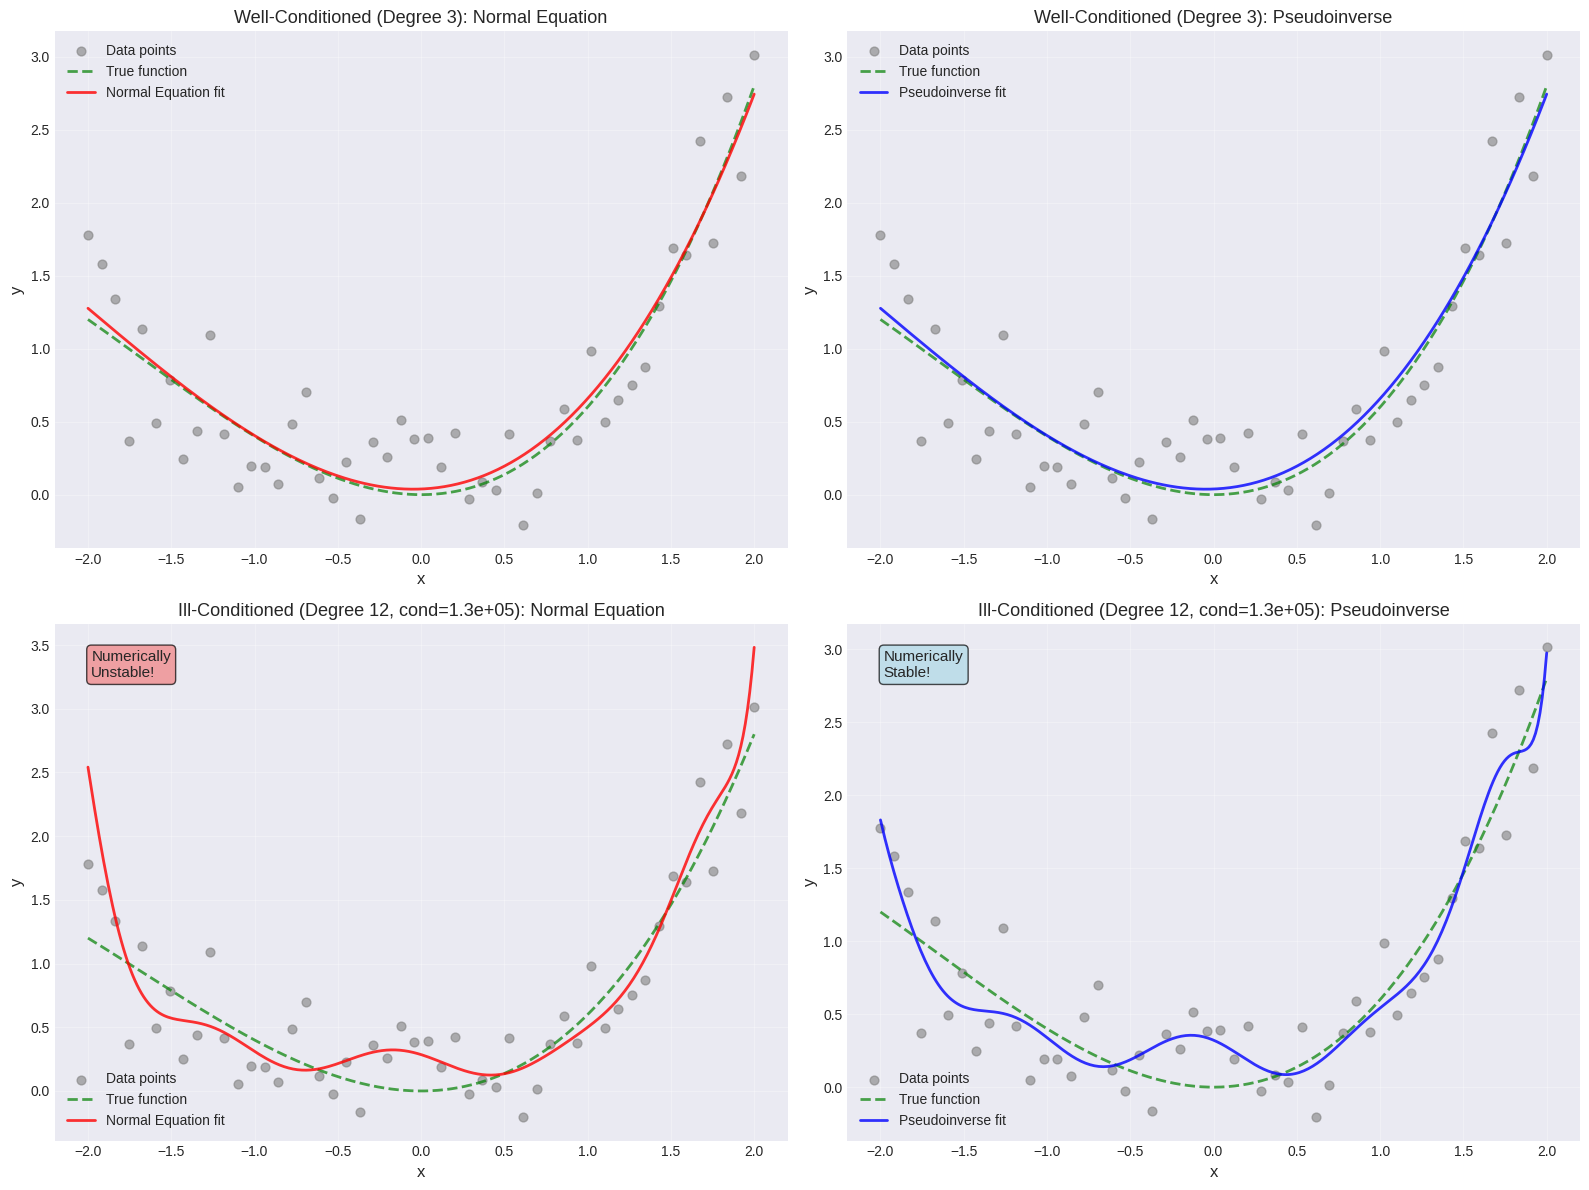

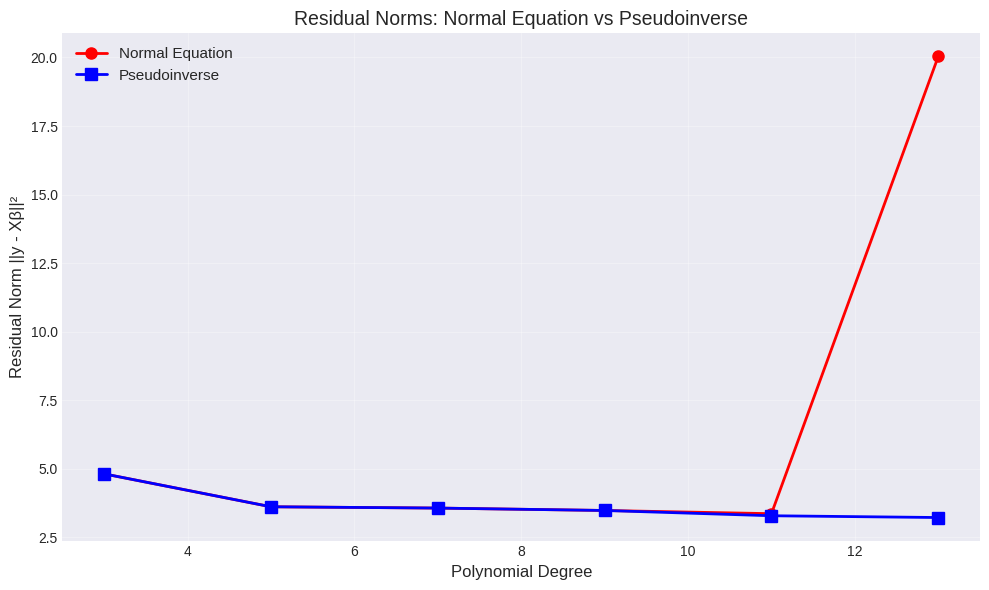


Summary
1. For well-conditioned systems, both methods give similar results.
2. For ill-conditioned systems, the Normal Equation becomes numerically unstable.
3. The pseudoinverse provides a more robust solution using SVD.
4. High-degree polynomials with power basis lead to ill-conditioned design matrices.
5. Using better basis functions (e.g., Legendre polynomials) improves conditioning.


In [5]:
# Function to predict using coefficients
def predict_polynomial_basis(x, beta, basis_func, degree):
    """
    Predict using coefficients and basis functions.
    """
    X = basis_func(x, degree)
    y_pred = torch.einsum('ij,jk->ik', X, beta)
    return y_pred

# Compare fits for well-conditioned case
print("=" * 70)
print("Visualization: Well-Conditioned Case (Degree 3)")
print("=" * 70)

degree_viz_well = 3
X_viz_well = construct_vandermonde_matrix(x, degree_viz_well)
beta_normal_viz_well = solve_normal_equation(X_viz_well, y)
beta_pinv_viz_well = solve_pseudoinverse(X_viz_well, y)

# Generate smooth x for plotting
x_plot = torch.linspace(x_min, x_max, 300).unsqueeze(1)
X_plot_well = construct_vandermonde_matrix(x_plot, degree_viz_well)

y_pred_normal_well = torch.einsum('ij,jk->ik', X_plot_well, beta_normal_viz_well)
y_pred_pinv_well = torch.einsum('ij,jk->ik', X_plot_well, beta_pinv_viz_well)

# Compare fits for ill-conditioned case
print("\n" + "=" * 70)
print("Visualization: Ill-Conditioned Case (Degree 12)")
print("=" * 70)

degree_viz_ill = 12
X_viz_ill = construct_vandermonde_matrix(x, degree_viz_ill)
cond_viz_ill = torch.linalg.cond(X_viz_ill).item()
print(f"Condition number: {cond_viz_ill:.2e}")

beta_normal_viz_ill = solve_normal_equation(X_viz_ill, y)
beta_pinv_viz_ill = solve_pseudoinverse(X_viz_ill, y)

X_plot_ill = construct_vandermonde_matrix(x_plot, degree_viz_ill)
y_pred_normal_ill = torch.einsum('ij,jk->ik', X_plot_ill, beta_normal_viz_ill)
y_pred_pinv_ill = torch.einsum('ij,jk->ik', X_plot_ill, beta_pinv_viz_ill)

# Compute true function for comparison
y_true_plot = 0.5 * x_plot ** 2 + 0.1 * x_plot ** 3

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Well-conditioned case - Normal Equation
axes[0, 0].scatter(x.numpy(), y.numpy(), alpha=0.6, label='Data points', s=40, color='gray')
axes[0, 0].plot(x_plot.numpy(), y_true_plot.numpy(), 'g--', linewidth=2, 
                label='True function', alpha=0.7)
axes[0, 0].plot(x_plot.numpy(), y_pred_normal_well.numpy(), 'r-', linewidth=2, 
                label='Normal Equation fit', alpha=0.8)
axes[0, 0].set_xlabel('x', fontsize=12)
axes[0, 0].set_ylabel('y', fontsize=12)
axes[0, 0].set_title(f'Well-Conditioned (Degree {degree_viz_well}): Normal Equation', fontsize=13)
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Well-conditioned case - Pseudoinverse
axes[0, 1].scatter(x.numpy(), y.numpy(), alpha=0.6, label='Data points', s=40, color='gray')
axes[0, 1].plot(x_plot.numpy(), y_true_plot.numpy(), 'g--', linewidth=2, 
                label='True function', alpha=0.7)
axes[0, 1].plot(x_plot.numpy(), y_pred_pinv_well.numpy(), 'b-', linewidth=2, 
                label='Pseudoinverse fit', alpha=0.8)
axes[0, 1].set_xlabel('x', fontsize=12)
axes[0, 1].set_ylabel('y', fontsize=12)
axes[0, 1].set_title(f'Well-Conditioned (Degree {degree_viz_well}): Pseudoinverse', fontsize=13)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Ill-conditioned case - Normal Equation (may be unstable)
axes[1, 0].scatter(x.numpy(), y.numpy(), alpha=0.6, label='Data points', s=40, color='gray')
axes[1, 0].plot(x_plot.numpy(), y_true_plot.numpy(), 'g--', linewidth=2, 
                label='True function', alpha=0.7)
axes[1, 0].plot(x_plot.numpy(), y_pred_normal_ill.numpy(), 'r-', linewidth=2, 
                label='Normal Equation fit', alpha=0.8)
axes[1, 0].set_xlabel('x', fontsize=12)
axes[1, 0].set_ylabel('y', fontsize=12)
axes[1, 0].set_title(f'Ill-Conditioned (Degree {degree_viz_ill}, cond={cond_viz_ill:.1e}): Normal Equation', 
                     fontsize=13)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].text(0.05, 0.95, 'Numerically\nUnstable!', 
                transform=axes[1, 0].transAxes, fontsize=11,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

# Plot 4: Ill-conditioned case - Pseudoinverse (more stable)
axes[1, 1].scatter(x.numpy(), y.numpy(), alpha=0.6, label='Data points', s=40, color='gray')
axes[1, 1].plot(x_plot.numpy(), y_true_plot.numpy(), 'g--', linewidth=2, 
                label='True function', alpha=0.7)
axes[1, 1].plot(x_plot.numpy(), y_pred_pinv_ill.numpy(), 'b-', linewidth=2, 
                label='Pseudoinverse fit', alpha=0.8)
axes[1, 1].set_xlabel('x', fontsize=12)
axes[1, 1].set_ylabel('y', fontsize=12)
axes[1, 1].set_title(f'Ill-Conditioned (Degree {degree_viz_ill}, cond={cond_viz_ill:.1e}): Pseudoinverse', 
                     fontsize=13)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].text(0.05, 0.95, 'Numerically\nStable!', 
                transform=axes[1, 1].transAxes, fontsize=11,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

plt.tight_layout()
plt.show()

# Additional visualization: Residual comparison
degrees_residual = [3, 5, 7, 9, 11, 13]
residual_norms_normal = []
residual_norms_pinv = []

for d in degrees_residual:
    X_res = construct_vandermonde_matrix(x, d)
    beta_norm = solve_normal_equation(X_res, y)
    beta_pinv = solve_pseudoinverse(X_res, y)
    
    residual_norms_normal.append(compute_residual_norm(X_res, y, beta_norm))
    residual_norms_pinv.append(compute_residual_norm(X_res, y, beta_pinv))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(degrees_residual, residual_norms_normal, 'o-', linewidth=2, markersize=8, 
        label='Normal Equation', color='red')
ax.plot(degrees_residual, residual_norms_pinv, 's-', linewidth=2, markersize=8, 
        label='Pseudoinverse', color='blue')
ax.set_xlabel('Polynomial Degree', fontsize=12)
ax.set_ylabel('Residual Norm ||y - Xβ||²', fontsize=12)
ax.set_title('Residual Norms: Normal Equation vs Pseudoinverse', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("Summary")
print("=" * 70)
print("1. For well-conditioned systems, both methods give similar results.")
print("2. For ill-conditioned systems, the Normal Equation becomes numerically unstable.")
print("3. The pseudoinverse provides a more robust solution using SVD.")
print("4. High-degree polynomials with power basis lead to ill-conditioned design matrices.")
print("5. Using better basis functions (e.g., Legendre polynomials) improves conditioning.")
print("=" * 70)
